In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Load data
# Test dataset does not contain the target feature named "target", thus we will not use it 

train = pd.read_csv('data/train.csv')
test =  pd.read_csv('data/test.csv')
sample =  pd.read_csv('data/sample_submission.csv')

print(train.shape,test.shape,sample.shape)

(18359, 14) (15021, 13) (15021, 2)


In [3]:
# The response variable "target" is not included in the testset. It is given in the sample file
test["target"] = sample["target"]

In [4]:
# We first combine test and trainsets to have a general look at the data
df = train.append(test)
df.shape

(33380, 14)

In [5]:
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,23798,city_149,0.689,Male,Has relevent experience,no_enrollment,Graduate,STEM,3,100-500,Pvt Ltd,1,106,0
1,29166,city_83,0.923,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,<10,Funded Startup,1,69,0
2,46,city_16,0.910,NaN,Has relevent experience,no_enrollment,Graduate,STEM,6,50-99,Public Sector,2,4,0
3,18527,city_64,0.666,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,50-99,Pvt Ltd,1,26,0
4,21751,city_100,0.887,NaN,No relevent experience,no_enrollment,Masters,STEM,8,NaN,NaN,2,88,1


In [6]:
# for later use

df.to_pickle("data/df_raw.pkl")

In [7]:
# Lets have a look at which features are numerical and which are categorical, as well as missing values

pd.concat([ df.dtypes, df.isnull().sum(), pd.Series([round((i/df.shape[0])*100,2) for i in df.isnull().sum()], index=df.isnull().sum().index)], axis=1, keys=["dtypes","isnull sum", "isnull %"])

,dtypes,isnull sum,isnull %
enrollee_id,int64,0,0.00
city,object,0,0.00
city_development_index,float64,0,0.00
gender,object,7486,22.43
relevent_experience,object,0,0.00
enrolled_university,object,621,1.86
education_level,object,852,2.55
major_discipline,object,5231,15.67
experience,object,103,0.31
company_size,object,8830,26.45


In [8]:
print("we have {} categorical features and {} numerical features".format(df.select_dtypes(include='object').columns.shape[0], df.select_dtypes(include=["int","float"]).columns.shape[0]))

we have 10 categorical features and 4 numerical features


In [9]:
# We see right away that we can make the feature city numerical by removing the string "city_"
# Features with missing values less then 3%, i.e. enrolled_university, education_level, experience, last_new_job, will be imuted with the 
# most frequent value

df['city'] = df['city'].apply(lambda x: x.split('_')[1])
df['city'] = df['city'].astype(int)

In [10]:
cols_fill_mode = ["enrolled_university", "education_level", "experience", "last_new_job"]

for col in cols_fill_mode:
    df[col].fillna(df[col].mode()[0], inplace=True)

In [11]:
df_overview = pd.concat([ pd.Series([df[i].unique().shape[0] for i in df.isnull().sum().index], index=df.isnull().sum().index) , df.isnull().sum(), pd.Series([round((i/df.shape[0])*100,2) for i in df.isnull().sum()], index=df.isnull().sum().index)], axis=1, keys=["unique values","isnull sum", "isnull %"])
df_overview

,unique values,isnull sum,isnull %
enrollee_id,33380,0,0.00
city,123,0,0.00
city_development_index,93,0,0.00
gender,4,7486,22.43
relevent_experience,2,0,0.00
enrolled_university,3,0,0.00
education_level,5,0,0.00
major_discipline,7,5231,15.67
experience,22,0,0.00
company_size,9,8830,26.45


In [12]:
###########################

# We can first do some preproccessing by just looking at the unique values 

###########################

In [13]:
df['relevent_experience'].unique()

array(['Has relevent experience', 'No relevent experience'], dtype=object)

In [14]:
df['relevent_experience'] = df['relevent_experience'].replace("Has relevent experience",1)
df['relevent_experience'] = df['relevent_experience'].replace("No relevent experience",0)

In [15]:
df['enrolled_university'].unique()

array(['no_enrollment', 'Full time course', 'Part time course'],
      dtype=object)

In [16]:
df['enrolled_university'] = df['enrolled_university'].replace("Full time course",1)
df['enrolled_university'] = df['enrolled_university'].replace("no_enrollment",0)
df['enrolled_university'] = df['enrolled_university'].replace("Part time course",0.5)

In [17]:
df.experience.unique()

array(['3', '14', '6', '8', '>20', '4', '9', '15', '10', '1', '5', '16',
       '11', '12', '7', '2', '13', '<1', '19', '18', '17', '20'],
      dtype=object)

In [18]:
df['experience'] = df['experience'].replace("<1","0")
df['experience'] = df['experience'].replace(">20","21")
df['experience'] = df['experience'].astype(int)

In [19]:
df.experience.unique()

array([ 3, 14,  6,  8, 21,  4,  9, 15, 10,  1,  5, 16, 11, 12,  7,  2, 13,
        0, 19, 18, 17, 20])

In [20]:
df.company_size.unique()

array(['100-500', '<10', '50-99', nan, '5000-9999', '10000+', '1000-4999',
       '500-999', '10/49'], dtype=object)

In [21]:
df['company_size'] = df['company_size'].replace("10/49","10-49")
df['company_size'] = df['company_size'].replace("<10","1-9")
df['company_size'] = df['company_size'].replace("10000+","10000")

In [22]:
df.last_new_job.unique()

array(['1', '2', '3', '>4', 'never', '4'], dtype=object)

In [23]:
df['last_new_job'] = df['last_new_job'].replace(">4","5")
df['last_new_job'] = df['last_new_job'].replace("never","0")
df['last_new_job'] = df['last_new_job'].astype(int)

In [24]:
pd.concat([ df.dtypes, pd.Series([df[i].unique().shape[0] for i in df.isnull().sum().index], index=df.isnull().sum().index), df.isnull().sum(), pd.Series([round((i/df.shape[0])*100,2) for i in df.isnull().sum()], index=df.isnull().sum().index)], axis=1, keys=["dtypes","unique values","isnull sum", "isnull %"])

,dtypes,unique values,isnull sum,isnull %
enrollee_id,int64,33380,0,0.00
city,int64,123,0,0.00
city_development_index,float64,93,0,0.00
gender,object,4,7486,22.43
relevent_experience,int64,2,0,0.00
enrolled_university,float64,3,0,0.00
education_level,object,5,0,0.00
major_discipline,object,7,5231,15.67
experience,int64,22,0,0.00
company_size,object,9,8830,26.45


In [25]:
df["gender"].unique()

array(['Male', nan, 'Female', 'Other'], dtype=object)

In [26]:
df_non_missing = df.dropna()
df_non_missing.shape[0] / df.shape[0]

0.5059616536848413

In [27]:
# We label the missing values with each own label "not_known" 

df = df.fillna("not_known")

In [28]:
df.isnull().any()

enrollee_id               False
city                      False
city_development_index    False
gender                    False
relevent_experience       False
enrolled_university       False
education_level           False
major_discipline          False
experience                False
company_size              False
company_type              False
last_new_job              False
training_hours            False
target                    False
dtype: bool

In [29]:
# Imputing for categorical features 
#  We will consider both applying a Labelencoder as well as one hot encoding

cat_cols = df.select_dtypes(include="object").columns
cat_cols

Index(['gender', 'education_level', 'major_discipline', 'company_size',
       'company_type'],
      dtype='object')

In [34]:
# Label Encoder 

from sklearn import preprocessing 
label_encoder = preprocessing.LabelEncoder() 

df_le = df.copy()
for col in cat_cols:
    df_le[col] = label_encoder.fit_transform(df_le[col])

In [35]:
# One hot encoding
df_oh = pd.get_dummies(df)

In [36]:
# Now we have no longer any missing values 
# We split the dataset back into train and test and proceed with the preprocessing

train_le = df_le.iloc[:train.shape[0]]
test_le = df_le.iloc[train.shape[0]:]

train_oh = df_oh.iloc[:train.shape[0]]
test_oh = df_oh.iloc[train.shape[0]:]

In [38]:
X_train_le = train_le.drop("target", axis=1)
y_train = train_le["target"]

X_test_le = test_le.drop("target", axis=1)
y_test = test2["target"]

X_train_oh = train_oh.drop("target", axis=1)
X_test_oh = test_oh.drop("target", axis=1)

In [39]:
# Normalizing
from sklearn.preprocessing import MinMaxScaler

def normalize(X_train, X_test):
    norm = MinMaxScaler().fit(X_train)
    X_train_norm = norm.transform(X_train)
    X_test_norm = norm.transform(X_test)
    return X_train_norm, X_test_norm


In [40]:
X_train_norm_le, X_test_norm_le = normalize(X_train_le, X_test_le)

In [41]:
X_train_norm_oh, X_test_norm_oh = normalize(X_train_oh, X_test_oh)

In [42]:
# we save them for later use

train_le.to_pickle("data/train_le.pkl")
test_le.to_pickle("data/test_le.pkl")

train_oh.to_pickle("data/train_oh.pkl")
test_oh.to_pickle("data/test_oh.pkl")

In [43]:
dd_le = train_le.append(test_le)
dd_oh = train_oh.append(test_oh)

In [45]:
dd_le.to_pickle("data/df_le.pkl")

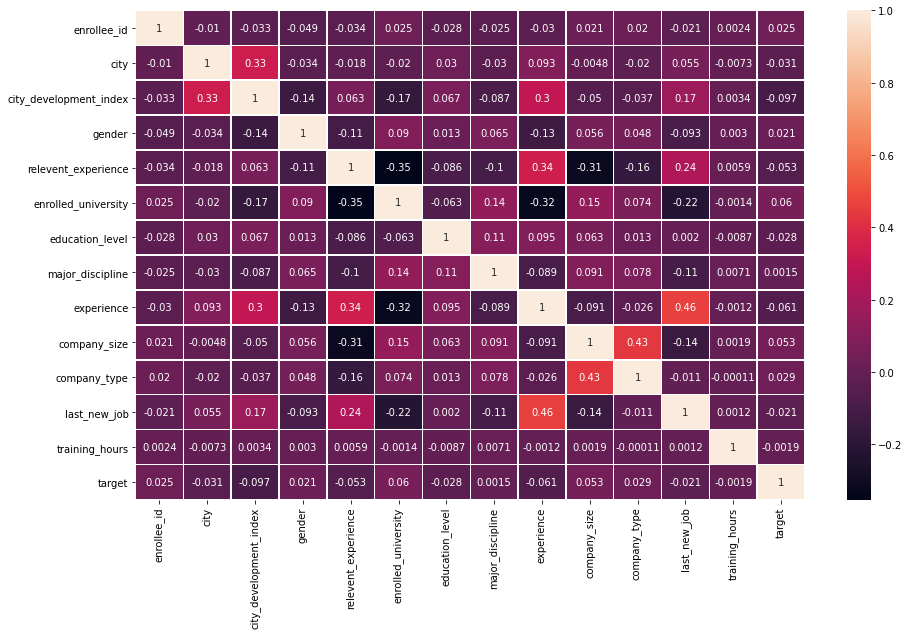

In [44]:
plt.subplots(figsize=(15, 9))
cor = dd_le.corr()
sns.heatmap(cor, annot=True, linewidths=.5)
plt.show()